In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import seaborn as sns

from lib.game_state import GameState
from lib.player.naive_player import NaivePlayer
from lib.words.simple_word_list import SimpleWordList
from lib.words.word_index import WordIndex
from lib.words.word_loader import WordLoader
from lib.stat_ranker import StatRanker
from lib.random_ranker import RandomRanker

In [3]:
def get_stats(runs, words, ranker):
    wordlen = 5

    print('running games')
    guesses = []
    words = WordIndex(word_list)
    for i in range(runs):
        n_guesses = run_game(words, wordlen, ranker=ranker)
        guesses.append(n_guesses)
    return guesses

def run_game(words, wordlen=5, ranker=None):
    state = GameState(words.list)
    ranker = ranker or RandomRanker(words.list)
    player = NaivePlayer(state, words=words, ranker=ranker)
    result = None
    while True:
        guess = player.guess(state, prev=result)
        result = state.update(guess)

        if guess == state.answer:
            return state.guesses
        else:
            player.update_state(result)

running games
running games


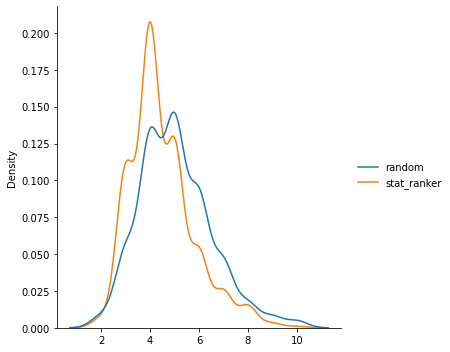

In [10]:
RUNS = 500

word_list = WordLoader.load_wordlist(sample_size=10000)
    
rand_ranker = RandomRanker(word_list)
rand_stats = get_stats(RUNS, word_list, rand_ranker)

stat_ranker = StatRanker(word_list)
stat_stats = get_stats(RUNS, word_list, stat_ranker)


data = {
    "random": rand_stats,
    "stat_ranker": stat_stats,
}

sns.displot(data, kind="kde")